In [105]:
import numpy as np
import sympy as symp
import scipy as scip
import matplotlib.pyplot as plt
import math as math


Using 37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel

Oxidizer to Fuel Ratio = 4.2:1
Chamber pressure = 1.00 MPa
Chamber temperature = 2933.5 K
Throat diameter = 47.395 mm
Throat Area = 1764.2289 mm^2
Nozzle expansion ratio = 100
Nozzle exit diameter = 0.4740 m
Nozzle exit area = 0.1764 m^2

Using basic compressible fluid equation with constant properties assumption (without integral over volume)
    Exhaust mach number = 4.6818
    Effective exhaust velocity = 3059.9708 m/s
    C* Efficiency = 1622.1637 m/s
    Exhaust temperature = 1010.2559 K
    Exhaust pressure = 744.3735 Pa
    Specific Impulse (Isp) = 312.0191 s
    Density Impulse = 483629.5276 kg-s/m^3

Using NASA-CEA Result (accounting for the change in properties)
    CEA Exhaust mach number = 4.9940
    CEA Effective exhaust velocity = 3188.6690 m/s
    CEA C* Efficiency = 1622.0000 m/s
    CEA Exhaust temperature = 964.0300 K
    CEA Exhaust pressure = 460.0000 Pa
    CEA Specific Impulse (Isp) = 335

/var/folders/j3/dr9c4mcx23gcdm0215yvb0h00000gn/T/ipykernel_46084/2258719640.py:224: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  h = float(result)


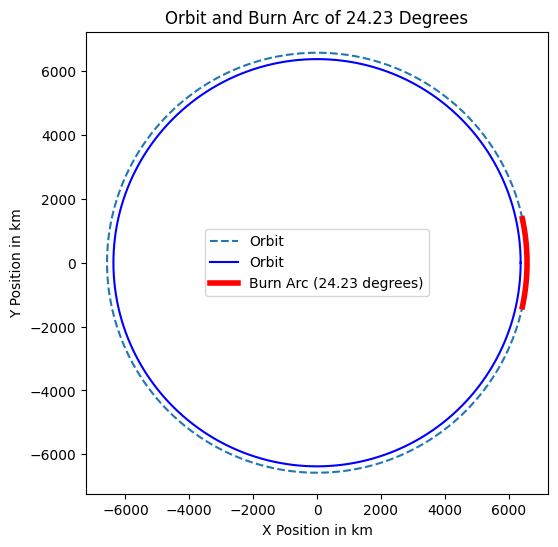

[312.01905005220465, 0.636769972889017]

In [106]:
def rocket_performance(Name, Pc, dt, Tc, gamma_comb, gamma_exit, R_comb, R_exit, OF, Pa, g0, mass_dry, nozzle_expansion_ratio, density_ox, density_fuel, h1, h2, L_star, a, n, iter_num, CEA_res, disp):
    
    #CEA Real Output : CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp
    CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp = CEA_res
    CEA_ve = CEA_v_sonic*CEA_Me
    CEA_density_ISP = CEA_Isp * density_ox
    
    # Derived values
    At = math.pi/4*dt**2
    dt2 = math.sqrt(4 / math.pi * nozzle_expansion_ratio * At)  # Nozzle exit diameter
    Ae = nozzle_expansion_ratio * At  # Nozzle exit area in square meters
    
    gamma_avg = (gamma_comb + gamma_exit)/2
    R_avg = (R_comb + R_exit)/2
    
    # Step 2: Calculate Effective Exhaust Velocity (ve) and Specific Impulse (ISP)
    def exit_mach_number_func(M, nozzle_expansion_ratio, gamma):
        return (nozzle_expansion_ratio - (1 / M) * ((2 / (gamma + 1)) * (1 + (gamma - 1) / 2 * M**2))**((gamma + 1) / (2 * (gamma - 1))))

    Me = float(scip.optimize.fsolve(exit_mach_number_func, 5, args=(nozzle_expansion_ratio, gamma_avg))[0])
    Te = Tc * (1 + (gamma_avg - 1) / 2 * Me**2) ** -1
    Pe = Pc * (1 + (gamma_avg - 1) / 2 * Me**2) ** (-gamma_avg / (gamma_avg - 1))
    ve = Me * math.sqrt(gamma_exit * R_exit * Te)
    c_star = math.sqrt(R_comb*Tc)/(math.sqrt(gamma_comb)*(2/(gamma_comb+1))**((gamma_comb+1)/(2*gamma_comb-2)))
    ISP = ve / g0
    density_ISP = ISP * density_ox
    
    # Step 3: Calculate the mass flow rate (dot_m)
    mass_flow_rate = (Pc * At / math.sqrt(Tc)) * math.sqrt(gamma_comb / R_comb) * ((2 / (gamma_comb + 1)) ** ((gamma_comb + 1) / (2 * (gamma_comb - 1))))
    oxidizer_mass_flow_rate = mass_flow_rate * OF / (1 + OF)
    fuel_mass_flow_rate = mass_flow_rate - oxidizer_mass_flow_rate

    CEA_mass_flow_rate = Pc*At/CEA_c_star
    CEA_oxidizer_mass_flow_rate = CEA_mass_flow_rate * OF / (1 + OF)
    CEA_fuel_mass_flow_rate = CEA_mass_flow_rate - CEA_oxidizer_mass_flow_rate

    # Step 4: Calculate Thrust (Ft)
    thrust = mass_flow_rate * ve + (Pe - Pa) * Ae
    
    CEA_thrust = CEA_mass_flow_rate * CEA_ve + (CEA_Pe - Pa) * Ae

    # Step 5: Delta V Calculation
    R_E = 6378e3  # Earth's radius in meters
    mu = 3.985894e14  # Standard gravitational parameter for Earth in m^3/s^2

    # Initial and final orbital radii
    r1 = R_E + h1
    r2 = R_E + h2

    # Semi-major axis of the transfer orbit
    a_t = (r1 + r2) / 2

    # Orbital velocities
    v1 = math.sqrt(mu / r1)  # Initial orbit velocity
    vp = math.sqrt((2 * mu / r1) - (mu / a_t))  # Velocity at perigee of transfer orbit
    va = math.sqrt((2 * mu / r2) - (mu / a_t))  # Velocity at apogee of transfer orbit
    v2 = math.sqrt(mu / r2)  # Final orbit velocity

    # Delta V for each burn
    delta_v1 = vp - v1
    delta_v2 = v2 - va

    # Total Delta V
    delta_v_total = delta_v1 + delta_v2

    # Using Tsiolkovsky's rocket equation to find propellant mass
    mass_propellant = mass_dry * (math.exp(delta_v_total / ve) - 1)
    mass_oxidizer = mass_propellant * OF / (OF + 1)
    mass_fuel = mass_propellant-mass_oxidizer
    volume_fuel = (mass_propellant - mass_oxidizer)/density_fuel
    volume_oxidizer = mass_oxidizer/density_ox
    burn_time = mass_oxidizer / oxidizer_mass_flow_rate
    
    CEA_mass_propellant = mass_dry * (math.exp(delta_v_total / CEA_ve) - 1)
    CEA_mass_oxidizer = CEA_mass_propellant * OF / (OF + 1)
    CEA_mass_fuel = CEA_mass_propellant - CEA_mass_oxidizer
    CEA_volume_fuel = (CEA_mass_propellant - CEA_mass_oxidizer)/density_fuel
    CEA_volume_oxidizer = CEA_mass_oxidizer/density_ox
    CEA_burn_time = CEA_mass_oxidizer / CEA_oxidizer_mass_flow_rate
    
    # Calculate final mass after first burn
    mass_initial = mass_propellant + mass_dry
    mass_f1 = mass_initial * math.exp(-delta_v1 / ve)
    
    
    CEA_mass_initial = CEA_mass_propellant + mass_dry
    CEA_mass_f1 = CEA_mass_initial * math.exp(-delta_v1 / CEA_ve)
    
    # Calculate propellant mass required for first burn
    mass_propellant_parking = mass_initial - mass_f1
    
    CEA_mass_propellant_parking = CEA_mass_initial - CEA_mass_f1
    
    # Calculate final mass after second burn
    mass_f2 = mass_f1 * math.exp(-delta_v2 / ve)
    
    CEA_mass_f2 = CEA_mass_f1 * math.exp(-delta_v2 / CEA_ve)
    
    # Calculate propellant mass required for second burn
    mass_propellant_injection = mass_f1 - mass_f2
    
    CEA_mass_propellant_injection = CEA_mass_f1 - CEA_mass_f2
    
    parking_burn_time = mass_propellant_parking * OF / (OF+1) / oxidizer_mass_flow_rate
    injection_burn_time = mass_propellant_injection * OF / (OF+1) / oxidizer_mass_flow_rate
    
    CEA_parking_burn_time = CEA_mass_propellant_parking * OF / (OF+1) / CEA_oxidizer_mass_flow_rate
    CEA_injection_burn_time = CEA_mass_propellant_injection * OF / (OF+1) / CEA_oxidizer_mass_flow_rate

    # Calculate the orbital period at LEO (T)
    LEO_period = 2 * math.pi * math.sqrt(r1**3 / mu)
    
    # Calculate time to traverse 10 degrees of the orbit
    arc_degrees = parking_burn_time*360/LEO_period
    
    CEA_arc_degrees = CEA_parking_burn_time*360/LEO_period
    
    #Nozzle Length for 100% Bell Nozzle
    LN_cone = 0.8*(math.sqrt(nozzle_expansion_ratio)-1)*dt/2/math.tan(math.radians(15))
    
    #Bell Nozzle Length based on 15 deg Conical Nozzle
    #Lc = L_star*(dt/dc)**2
    #contraction_ratio = (dc/dt)**2
    
    Dpi = math.sqrt((4*CEA_oxidizer_mass_flow_rate)/(math.pi*500))
    # Define lower and upper bounds
    lb = [200e-3, 0]  # Lower bounds Dpi, Dpf, L
    ub = [425e-3, 2.0]  # Upper bounds Dpi, Dpf, L
    bounds = [(low, high) for low, high in zip(lb, ub)]
    #np.random.seed(100)

    # Define the objective function (sum of squared residuals)
    def hybrid_equation(x, volume_fuel0, fuel_mass_flow_rate0, oxidizer_mass_flow_rate0, burn_time0):
        Dpf, L = x

        # Fuel Volume Equation
        F1 = volume_fuel0 - (math.pi/4*(Dpf**2-Dpi**2)*L)
    
        # Fuel Mass Flow Rate Equation
        F2 = fuel_mass_flow_rate0 - (density_fuel*math.pi*Dpi*L*a*((4*oxidizer_mass_flow_rate0)/(math.pi*Dpi**2))**n)
    
        # Approximate Burn Time Relation
        F3 = burn_time0 - ((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*oxidizer_mass_flow_rate0**n)
    
        # Sum of squared residuals
        #return F1**2 + F2**2 + F3**2 + F4**2
        return [F1, F2, F3]

    # Normalization function for better scaling
    def normalize_residuals(residuals):
        # Scale each residual by a factor that brings them into a similar range
        scales = [1.0, 1, 1]  # Example scales, adjust as needed
        return [residuals[i] / scales[i] for i in range(len(residuals))]

    # Objective function for minimization (sum of squares of normalized residuals)
    def objective_function(x):
        residuals = hybrid_equation(x,CEA_volume_fuel, CEA_fuel_mass_flow_rate, CEA_oxidizer_mass_flow_rate, CEA_burn_time)
        normalized_residuals = normalize_residuals(residuals)
        return sum([r**2 for r in normalized_residuals])

    '''
    # Define the objective function (sum of squared residuals)
    def CEA_hybrid_equation(x, volume_fuel0, fuel_mass_flow_rate0, oxidizer_mass_flow_rate0, burn_time0):
        Dpi, Dpf, L = x

        # Fuel Volume Equation
        F1 = volume_fuel0 - (math.pi/4*(Dpf**2-Dpi**2)*L)
    
        # Fuel Mass Flow Rate Equation
        F2 = fuel_mass_flow_rate0 - (density_fuel*math.pi*Dpi*L*a*((4*oxidizer_mass_flow_rate0)/(math.pi*Dpi**2))**n)
    
        # Approximate Burn Time Relation
        F3 = burn_time0 - ((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*oxidizer_mass_flow_rate0**n)
    
        # Sum of squared residuals
        #return F1**2 + F2**2 + F3**2 + F4**2
        return [F1, F2, F3]

    # Objective function for minimization (sum of squares of normalized residuals)
    def CEA_objective_function(x):
        residuals = hybrid_equation(x,CEA_volume_fuel, CEA_fuel_mass_flow_rate, CEA_oxidizer_mass_flow_rate, CEA_burn_time)
        normalized_residuals = normalize_residuals(residuals)
        
        return sum([r**2 for r in normalized_residuals])
    '''
    # Initial guesses for unknowns : Dpi, Dpf, L
    x0 = np.array([350e-3, 0.5])

    # Basin Hopping Methods: Powell
    result = scip.optimize.basinhopping(objective_function,x0=x0,minimizer_kwargs={"method": "Powell", "bounds": bounds},niter=iter_num,T=0.5,stepsize=0.001,disp=False)
    
    Dpf, Grain_Length = result.x[0], result.x[1]
    #CEA_Dpi, CEA_Dpf, CEA_Grain_Length = CEA_result.x[0], CEA_result.x[1], CEA_result.x[2]
    
    Throat_area = math.pi/4*(dt)**2
    Volume_chamber_Lstar = L_star*Throat_area
    Volume_chamber_grain = math.pi/4*(Dpi)**2
    Volume_post_chamber = (Volume_chamber_Lstar-Volume_chamber_grain)
    Length_post_chamber = Volume_post_chamber/(math.pi/4*Dpf**2)
    Length_connector = (Dpf-dt)*0.5/math.tan(math.radians(60))
    #14 multi-port reduction in length by 70%
    Length_precombustor = 0.015
    Total_combustor_length = Length_post_chamber + Grain_Length + Length_precombustor
    
    Maximum_pump_diameter = 0.300
    Total_engine_length = Total_combustor_length + Length_connector + LN_cone
    Total_kickstage_length = Total_engine_length + Maximum_pump_diameter
    
    #Tank Geometry
    rho_tank = 2840 # Al-2219
    rho_insul = 417 # PU Foam
    rho_casing = 1550 # Carbon Fiber Composite
    rho_combustor = 21030 # Rhenium
    yield_combustor = 290e6
    t_insul = 10e-3
    t_tank = 1e-3
    Do = 913.40e-3
    Di = 450e-3
    width = Do/2-Di/2-2*t_tank-2*t_insul
    R = Di/2+t_insul+width/2+t_tank
    def tank_geom(h):
        return CEA_volume_oxidizer-((math.pi*width**2/4 + width*h)*(2*math.pi*R))
    result = scip.optimize.fsolve(tank_geom, 0.3)
    h = float(result)
    volume_tank = ((math.pi*(width+2*t_tank)**2/4 + (width+2*t_tank)*(h))*(2*math.pi*R))-((math.pi*width**2/4 + width*h)*(2*math.pi*R))
    volume_insul = ((math.pi*(width+2*t_tank+2*t_insul)**2/4 + (width+2*t_tank+2*t_insul)*(h))*(2*math.pi*R))-((math.pi*(width+2*t_tank)**2/4 + (width+2*t_tank)*(h))*(2*math.pi*R))
    
    mass_comb = (1/(Total_combustor_length/Dpf)+2)*rho_combustor/yield_combustor*2*Pc*Volume_chamber_Lstar
    mass_injector = 1/3*mass_comb
    mass_nozzle = rho_combustor/yield_combustor*2*(At*((nozzle_expansion_ratio-1)/math.sin(math.radians(15)))*(Dpf*Pc)/2)
    mass_battery = CEA_oxidizer_mass_flow_rate*1.2*4e5/density_ox/(0.65*0.92)/(265*3600)
    mass_pump = 12
    mass_motor = 0.5
    mass_tank = rho_tank*volume_tank
    mass_insul = rho_insul*volume_insul
    mass_casing = rho_casing*1.619*10**-2
    mass_other = 20
    mass_dry_kickstage = mass_comb + mass_injector + mass_nozzle + mass_battery + mass_pump + mass_motor + mass_tank + mass_insul + mass_casing + mass_other
    mass_payload = 100
    total_kickstage_wet_mass = CEA_mass_propellant + mass_dry_kickstage + mass_payload
    
    def plot_orbit_and_burn_arc(orbit_radius, arc_degrees):
        """
        Visualize the orbit and highlight the arc corresponding to a burn.
    
        Parameters:
        - orbit_radius: Radius of the orbit (in arbitrary units, e.g., km or AU)
        - arc_degrees: Arc length in degrees over which the burn occurs
        """
        # Full circle (orbit) points
        theta_full = np.linspace(0, 2 * np.pi, 1000)
        x_full = orbit_radius * np.cos(theta_full)
        y_full = orbit_radius * np.sin(theta_full)
        x_earth = 6378 * np.cos(theta_full)
        y_earth = 6378 * np.sin(theta_full)
        
        # Arc for the burn
        arc_radians = np.deg2rad(arc_degrees / 2)
        theta_arc = np.linspace(-arc_radians, arc_radians, 100)
        x_arc = orbit_radius * np.cos(theta_arc)
        y_arc = orbit_radius * np.sin(theta_arc)
    
        # Plotting the full orbit
        plt.figure(figsize=(6, 6))
        plt.plot(x_full, y_full, label='Orbit', linestyle='--')
        plt.plot(x_earth, y_earth, label='Orbit', linestyle='-', color='blue')
        
        # Highlighting the arc
        plt.plot(x_arc, y_arc, color='red', label=f'Burn Arc ({arc_degrees:.2f} degrees)', linestyle='-', linewidth=4)
    
        # Plot aesthetics
        plt.title(f"Orbit and Burn Arc of {arc_degrees:.2f} Degrees")
        plt.xlabel('X Position in km')
        plt.ylabel('Y Position in km')
        plt.axhline(0, color='black', linewidth=0)
        plt.axvline(0, color='black', linewidth=0)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.show()
        
        return
    
    if disp:
        print(f"\nUsing {Name}\n")

        # Print basic parameters
        print(f"Oxidizer to Fuel Ratio = {OF}:1")
        print(f"Chamber pressure = {Pc*1e-6:.2f} MPa")
        print(f"Chamber temperature = {Tc} K")
        print(f"Throat diameter = {dt*1000} mm")
        print(f"Throat Area = {At*10**6:.4f} mm^2")
        print(f"Nozzle expansion ratio = {nozzle_expansion_ratio}")
        print(f"Nozzle exit diameter = {dt2:.4f} m")
        print(f"Nozzle exit area = {Ae:.4f} m^2")
        
        print(f"\nUsing basic compressible fluid equation with constant properties assumption (without integral over volume)")
        print(f"    Exhaust mach number = {Me:.4f}")
        print(f"    Effective exhaust velocity = {ve:.4f} m/s")
        print(f"    C* Efficiency = {c_star:.4f} m/s")
        print(f"    Exhaust temperature = {Te:.4f} K")
        print(f"    Exhaust pressure = {Pe:.4f} Pa")
        print(f"    Specific Impulse (Isp) = {ISP:.4f} s")
        print(f"    Density Impulse = {density_ISP:.4f} kg-s/m^3")
        
        print(f"\nUsing NASA-CEA Result (accounting for the change in properties)")
        print(f"    CEA Exhaust mach number = {CEA_Me:.4f}")
        print(f"    CEA Effective exhaust velocity = {CEA_ve:.4f} m/s")
        print(f"    CEA C* Efficiency = {CEA_c_star:.4f} m/s")
        print(f"    CEA Exhaust temperature = {CEA_Te:.4f} K")
        print(f"    CEA Exhaust pressure = {CEA_Pe:.4f} Pa")
        print(f"    CEA Specific Impulse (Isp) = {CEA_Isp:.4f} s")
        print(f"    CEA Density Impulse = {CEA_density_ISP:.4f} kg-s/m^3")
    
        print(f"\nAll performance after this is calculated with NASA-CEA Results")
        print(f"\nPropellant Mass Flow Rate = {CEA_mass_flow_rate:.4f} Kg/s")
        print(f"Fuel Mass Flow Rate = {CEA_fuel_mass_flow_rate:.4f} Kg/s")
        print(f"Oxidizer Mass Flow Rate = {CEA_oxidizer_mass_flow_rate:.4f} Kg/s")
        print(f"Oxidizer Volumetric Flow Rate = {CEA_oxidizer_mass_flow_rate/1600*1000:.4f} L/s")
        
        print(f"\nThrust = {CEA_thrust:.4f} N")
        print(f"Thrust to Weight Ratio = {CEA_thrust/CEA_mass_initial/g0:.4f}")
        print(f"\nDelta V total = {delta_v_total:.4f} m/s")
        print(f"Total propellant mass used = {CEA_mass_propellant:.4f} kg")
        print(f"    Fuel mass used= {CEA_mass_fuel:.4f} kg")
        print(f"    Fuel volume = {CEA_volume_fuel*1000:.4f} L")
        print(f"    Oxidizer mass used= {CEA_mass_oxidizer:.4f} kg")
        print(f"    Oxidizer volume = {CEA_volume_oxidizer*1000:.4f} L")
        print(f"    Propellant mass used at parking = {CEA_mass_propellant_parking:.4f} kg")
        print(f"    Propellant mass used at injection = {CEA_mass_propellant_injection:.4f} kg")
        print(f"Dry mass = {mass_dry:.4f} kg")
        print(f"Total LEO wet mass = {CEA_mass_initial:.4f} kg")
        print(f"Total burn time = {CEA_burn_time:.2f} s")
        print(f"    Parking burn time = {CEA_parking_burn_time:.2f} s")
        print(f"    Injection burn time = {CEA_injection_burn_time:.2f} s")
        print(f"Orbital arc degrees over parking burn = {CEA_arc_degrees:.2f} deg")
        
        print(f"\nApproximated Ideal Hybrid Fuel Performance and Sizing")
        print(f"Fuel Grain Geometry")
        print(f"    Initial Port Diameter = {Dpi*1000:.4f} mm")
        print(f"    Final Port Diameter = {Dpf*1000:.4f} mm")
        print(f"    Fuel Grain Length = {Grain_Length*1000:.4f} mm")
        #print(f"    Approximate Multiport Fuel Grain Length = {Grain_Length*0.3*1000:.4f} mm")
        print(f"    Fuel grain volume = {(math.pi/4*(Dpf**2-Dpi**2)*Grain_Length)*1000:.4f} L")
        print(f"Hybrid fuel burn time = {((Dpf**(2*n+1)-Dpi**(2*n+1))*math.pi**n)/((2*n+1)*a*2**(2*n+1)*CEA_oxidizer_mass_flow_rate**n):.4f} s")
        print(f"Hybrid fuel mass flow rate = {(density_fuel*math.pi*Dpi*Grain_Length*a*((4*CEA_oxidizer_mass_flow_rate)/(math.pi*Dpi**2))**n):.4f} kg/s")
        print(f"Oxidizer mass flux initial= {CEA_oxidizer_mass_flow_rate/(math.pi/4*Dpi**2):.4f} kg/s-m^3")
        print(f"L* chamber volume = {Volume_chamber_Lstar*1000:.4f} L")
        print(f"Grain chamber volume = {Volume_chamber_grain*1000:.4f} L")
        print(f"Pre combustion chamber length = {Length_precombustor*1000:.4f} mm")
        print(f"Post combustion chamber length = {Length_post_chamber*1000:.4f} mm")
        print(f"Total combustion chamber length = {Total_combustor_length*1000:.4f} mm")
        print(f"Nozzle Length (LN) = {LN_cone*1000:.2f} mm")
        print(f"Total engine length = {Total_engine_length*1000:.4f} mm")
        print(f"Total kick stage length = {Total_kickstage_length*1000:.4f} mm")
        
        print(f"\nMass Calculation")
        print(f"Combustion chamber mass = {mass_comb:.4f} kg")
        print(f"Injector mass = {mass_injector:.4f} kg")
        print(f"Nozzle mass = {mass_nozzle:.4f} kg")
        print(f"Battery mass = {mass_battery:.4f} kg")
        print(f"Pump mass = {mass_pump:.4f} kg")
        print(f"Motor mass = {mass_motor:.4f} kg")
        print(f"Tank mass = {mass_tank:.4f} kg")
        print(f"Tank Insulation mass = {mass_insul:.4f} kg")
        print(f"Casing mass = {mass_casing:.4f} kg")
        print(f"Other mass = {mass_other:.4f} kg")
        print(f"Payload mass = {mass_payload:.4f} kg")
        print(f"Kick stage dry mass = {mass_dry_kickstage:.4f} kg")
        print(f"Total kick stage wet mass = {total_kickstage_wet_mass:.4f} kg")
        
        print(f"New thrust to weight ratio = {CEA_thrust/(total_kickstage_wet_mass*g0):.4f}")
        
        plot_orbit_and_burn_arc(r1/1000, CEA_arc_degrees)
    
    
    
    return [ISP, LN_cone]

# Example usage of the function with the given constants 1.1371
# From CEA, gamma at combustion chamber is 1.1371, and nozzle exit 1.2420, avg. 1.18955
# From CEA, Gas Constant (R) at combustion chamber is (8.3144598 J/mol-K)/21.468e-3, and nozzle exit (8.3144598 J/mol-K)/21.930e-3, avg. = 383.215917
# Assumed Ac/At = 10 (typical range, smaller the engine larger the Ac/At) in CEA. It doesn't affect rocket performance but the mixing of fuel (we assume the propellants are mixed properly)
#gamma_exit=1.2420  R_exit=8.3144598/21.930e-3

#print(rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.0254, Tc=2975.78, gamma_comb=1.1371, gamma_exit=1.2420, R_comb=8.3144598/21.468e-3, R_exit=8.3144598/21.930e-3, OF=6.3, Pa=0, g0=9.807, mass_dry=100, nozzle_expansion_ratio=125, density_ox=1550, h1=200e3, h2=35786e3, disp=False)[1])

#CEA-Run
#rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.0254*1, Tc=2975.78, gamma_comb=1.1371, gamma_exit=1.2420, R_comb=8.3144598/21.468e-3, R_exit=8.3144598/21.930e-3, OF=6.3, Pa=0, g0=9.807, mass_dry=140, nozzle_expansion_ratio=80, density_ox=1550, density_fuel=800, h1=200e3, h2=35786e3, L_star=1.0, disp=True)


#rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=20e5, dt=0.0254*1.23, Tc=2991.8, gamma_comb=1.1266, gamma_exit=1.2252, R_comb=8.3144598/23.276e-3, R_exit=8.3144598/24.086e-3, OF=4.2, Pa=0, g0=9.807, mass_dry=140, nozzle_expansion_ratio=140, density_ox=1550, density_fuel=1522, h1=200e3, h2=35786e3, L_star=1.0, disp=True)

#CEA-Run Hybrid Engine JANUS Compound 15 + HAN+H2O2

#CEA Real Output : CEA_Me, CEA_v_sonic, CEA_c_star, CEA_Te, CEA_Pe, CEA_Isp
set_of_cea_results = [4.994, 638.5, 1622.0, 964.03,0.00460e5,3292.7/9.807]
        
rocket_performance(Name = "37%HAN-63%H2O2 Oxidizer + JANUS's Compound 15 Hypergolic Hybrid Fuel", Pc=10e5, dt=0.047395, Tc=2933.5, gamma_comb=1.1225, gamma_exit=1.2249, R_comb=359.4664851, R_exit=345.1988624, OF=4.2, Pa=0, g0=9.807, mass_dry=210.9353, nozzle_expansion_ratio=100, density_ox=1550, density_fuel=1522, h1=200e3, h2=35786e3, L_star=10, a=9.39216799e-05, n=0.5, iter_num=1000, CEA_res = set_of_cea_results, disp=True)

#RPA-Run
#rocket_performance(Name = '37%HAN-63%H2O2 + RP-1 Propellant', Pc=30e5, dt=0.02565*1, Tc=2821.9317, gamma_comb=1.1467, gamma_exit=1.2524, R_comb=8.3144598/22.3014e-3, R_exit=8.3144598/22.6760e-3, OF=7.1, Pa=0, g0=9.807, mass_dry=140, nozzle_expansion_ratio=125, density_ox=1550, density_fuel=800, h1=200e3, h2=35786e3, disp=True)

